# Dementia Detection with MobileNet_v2

This notebook trains a machine learning system to detect dementia using the **MobileNet_v2** architecture. The training is based on images of spectrograms created in a separate notebook: `image_creator.ipynb`. 

## Data Source

The dataset used for training and testing is the **PROCESS-V1** dataset, which can be downloaded here:  
[Download PROCESS-V1 Dataset](https://syncandshare.lrz.de/getlink/fiSPLrnFVFo3DvWqXkLGdY/PROCESS-V1_test.zip)

- Only fully labeled data from the dataset is used for image grouping.

## Methodology

1. **Spectrogram Generation**:  
   Spectrograms are pre-generated in `image_creator.ipynb`.

2. **Training**:  
   - The MobileNet_v2 model is fine-tuned for dementia detection. 
   - The notebook includes versions for:
     - **2-class classification** (e.g., dementia vs. non-dementia).
     - **3-class classification** based on the original dataset labels.
   - Fast training is facilitated by using an NVIDIA graphics card with a **2000 Series or newer**.

3. **Results Verification**:  
   - Model interpretability is verified using **LIME (Local Interpretable Model-agnostic Explanations)**.
   - A **confusion matrix** is generated to evaluate classification performance.


In [1]:
!nvidia-smi
#!pip install imbalanced-learn
!pip install lime

Sun Jan 19 19:44:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
| 41%   31C    P8             14W /  130W |    2341MiB /   8192MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Updated weights usage
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 2 classes: Healthy and Not Healthy
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed precision training setup
scaler = GradScaler()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=20)

# Save the trained model
torch.save(model.state_dict(), "spectrogram_classifier_20.pth")


print("Model saved as spectrogram_classifier_20.pth")

Using device: cuda
Epoch 1/20
Train Loss: 0.7439, Train Acc: 0.5179
Epoch 2/20
Train Loss: 0.7058, Train Acc: 0.5322
Epoch 3/20
Train Loss: 0.7049, Train Acc: 0.5336
Epoch 4/20
Train Loss: 0.6997, Train Acc: 0.5397
Epoch 5/20
Train Loss: 0.7191, Train Acc: 0.5313
Epoch 6/20
Train Loss: 0.6943, Train Acc: 0.5395
Epoch 7/20
Train Loss: 0.6916, Train Acc: 0.5311
Epoch 8/20
Train Loss: 0.6975, Train Acc: 0.5467
Epoch 9/20
Train Loss: 0.6919, Train Acc: 0.5420
Epoch 10/20
Train Loss: 0.6904, Train Acc: 0.5543
Epoch 11/20
Train Loss: 0.6933, Train Acc: 0.5428
Epoch 12/20
Train Loss: 0.6993, Train Acc: 0.5322
Epoch 13/20
Train Loss: 0.6917, Train Acc: 0.5504
Epoch 14/20
Train Loss: 0.6902, Train Acc: 0.5436
Epoch 15/20
Train Loss: 0.6871, Train Acc: 0.5588
Epoch 16/20
Train Loss: 0.6909, Train Acc: 0.5453
Epoch 17/20
Train Loss: 0.6894, Train Acc: 0.5470
Epoch 18/20
Train Loss: 0.6874, Train Acc: 0.5540
Epoch 19/20
Train Loss: 0.6893, Train Acc: 0.5574
Epoch 20/20
Train Loss: 0.6877, Train Ac

In [3]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
data_dir = r"F:\Peter\ML_exp\PROCESS-V1\Spectrograms"  # Replace with the path to the spectrograms
healthy_dir = os.path.join(data_dir, "Healthy")
not_healthy_dir = os.path.join(data_dir, "Not Healthy")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets and split into train/validation sets
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # ['Healthy', 'Not Healthy']

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained ResNet)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='binary'):
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

import numpy as np

def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam


# Training and Validation function
# Define the updated train_model function with advanced overfitting detection
def train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha=1.0
    weight_decay = 1e-4
    overfitting_threshold = 3  # Number of consecutive epochs of overfitting to trigger adjustments
    overfitting_epochs = 0

    # Track historical loss differences for smarter overfitting detection
    loss_differences = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

        # --- Smarter Overfitting Detection ---
        loss_diff = val_loss - train_loss
        acc_diff = train_acc - val_acc
        loss_differences.append(loss_diff)

        # Check rolling average of loss differences
        if len(loss_differences) > 3:
            rolling_avg_loss_diff = np.mean(loss_differences[-3:])
            if rolling_avg_loss_diff > 0.1 and acc_diff > 0.1:
                overfitting_epochs += 1
                print(f"Overfitting detected (Rolling Loss Diff: {rolling_avg_loss_diff:.4f}).")
            else:
                overfitting_epochs = 0

        if overfitting_epochs >= overfitting_threshold:
            print("Overfitting persists. Adjusting learning rate and weight decay.")
            lr *= 0.5
            weight_decay *= 0.9
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                param_group['weight_decay'] = weight_decay
            overfitting_epochs = 0  # Reset counter

    # Explain model predictions with LIME after training
    explain_with_lime(model, val_loader, device)

# SMOTE: Handle imbalanced datasets
def apply_smote(train_loader):
    smote = SMOTE()
    train_data = []
    train_labels = []

    for inputs, labels in train_loader:
        train_data.extend(inputs.view(inputs.size(0), -1).numpy())
        train_labels.extend(labels.numpy())

    train_data_smote, train_labels_smote = smote.fit_resample(np.array(train_data), np.array(train_labels))
    print("SMOTE applied. Resampled dataset size:", len(train_labels_smote))

    return train_data_smote, train_labels_smote





# Preprocess dataset with SMOTE
#train_data_smote, train_labels_smote = apply_smote(train_loader)

# Train model with the new improvements
#train_model_with_smote_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)



# Train the model
#train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=15)

# Save the final trained model
#torch.save(model.state_dict(), "final_spectrogram_classifier_15.pth")
print("Model saved as final_spectrogram_classifier_15.pth")


Using device: cuda
Model saved as final_spectrogram_classifier_15.pth


**Now with 3 classes (based on dataset)**


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LIME: Explain predictions
def explain_with_lime(model, val_loader, device):
    explainer = LimeImageExplainer()

    model.eval()
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            sample_image = inputs[0].cpu().numpy().transpose(1, 2, 0)

            explanation = explainer.explain_instance(
                image=sample_image,
                classifier_fn=lambda x: model(torch.tensor(x.transpose(0, 3, 1, 2)).float().to(device)).detach().cpu().numpy(),
                top_labels=2,
                hide_color=0,
                num_samples=1000
            )

            temp, mask = explanation.get_image_and_mask(
                label=1,  # Assuming class 1 is "Not Healthy"
                positive_only=True,
                num_features=10,
                hide_rest=False
            )

            lime_image = mark_boundaries(temp, mask)
            plt.imshow(lime_image)
            plt.title("LIME Explanation")
            plt.show()
            break  # Explain one sample for demonstration
# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with confusion matrix
def train_model_with_confusion_matrix(model, criterion, optimizer, train_loader, val_loader, device, epochs=10):
    best_val_f1 = 0.0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Plot confusion matrix for validation results
    print("\nConfusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds, class_names)



# With Cross Validation #

In [30]:
def cutmix(data, targets, alpha=1.0):
    """Apply CutMix augmentation on a batch of data and targets."""
    indices = torch.randperm(data.size(0))  # Shuffle batch indices
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    # Sample the lambda parameter from a Beta distribution
    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    # Compute the bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly select the center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Mix the images and adjust the labels
    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot training and validation loss and accuracy
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Training and validation function with metric tracking, visualization, and early stopping
def train_model_with_plots_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10, patience=5):
    best_val_f1 = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
            print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print("Unique classes in labels:", np.unique(all_labels))
        print("Unique classes in predictions:", np.unique(all_preds))

        # Plot confusion matrix for validation results
        if epoch == epochs - 1 or patience_counter >= patience:  # Plot confusion matrix after last epoch or early stop
            print("\nConfusion Matrix:")
            plot_confusion_matrix(all_labels, all_preds, class_names)

    print("Training completed.")


    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)

    # Explain model predictions with LIME
    explain_with_lime(model, val_loader, device)



In [44]:
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, Subset
# Arrays to store results

from sklearn.model_selection import StratifiedKFold

def train_with_cross_validation(dataset, model_fn, criterion_fn, device, epochs=10, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    from collections import Counter

    # 1. Get all targets
    all_targets = [dataset[i][1] for i in range(len(dataset))]

    # 2. Set up stratified folding
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(dataset)), all_targets)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")

        # 3. Create Subset for train and validation
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)

        # 4. Build WeightedRandomSampler for the TRAIN subset only
        train_targets = [dataset[i][1] for i in train_idx]
        class_counts = Counter(train_targets)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[label] for label in train_targets]

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # 5. DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler, num_workers=2)
        val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=2)

        # 6. Instantiate a new model and move it to the device
        model = model_fn(num_classes).to(device)

        # 7. Define a new optimizer for this fold
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # 8. Initialize a new scaler for mixed precision
        scaler = GradScaler()

        # 9. Train the model
        train_model_with_plots_and_explainability(
            model, criterion_fn, optimizer, train_loader, val_loader, device,
            epochs=epochs, patience=5, scaler=scaler
        )

        # 10. Load the best model for evaluation
        model.load_state_dict(torch.load("best_model.pth"))

        # Evaluate on the validation set
        val_correct, val_total, all_labels, all_preds = 0, 0, [], []

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = val_correct / val_total
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)
        fold_results.append((val_acc, val_f1, val_precision, val_recall))

        print(f"Fold {fold + 1} Results - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")


    # Average results across folds
    avg_results = {
        "Accuracy": sum(result[0] for result in fold_results) / n_splits,
        "F1": sum(result[1] for result in fold_results) / n_splits,
        "Precision": sum(result[2] for result in fold_results) / n_splits,
        "Recall": sum(result[3] for result in fold_results) / n_splits,
    }
    print("\n--- Cross-Validation Results ---")
    print(avg_results)
    # Calculate and display argmax, argmin, mean, and standard deviation for each metric
    fold_results = np.array(fold_results)
    metrics = ['Accuracy', 'F1', 'Precision', 'Recall']

    for i, metric in enumerate(metrics):
        max_value = np.max(fold_results[:, i])
        min_value = np.min(fold_results[:, i])
        mean_value = np.mean(fold_results[:, i])
        std_value = np.std(fold_results[:, i])
        max_fold = np.argmax(fold_results[:, i]) + 1  # 0-based to 1-based
        min_fold = np.argmin(fold_results[:, i]) + 1

        print(f"\n{metric} - Max: {max_value:.4f} (Fold {max_fold}), "
              f"Min: {min_value:.4f} (Fold {min_fold}), "
              f"Mean: {mean_value:.4f}, Std Dev: {std_value:.4f}")
    return avg_results

# Function to reset model weights (useful for each fold)
def reset_weights(layer):
    if hasattr(layer, "reset_parameters"):
        layer.reset_parameters()

# Example usage:
#train_with_cross_validation(dataset, model, criterion, optimizer, device, epochs=2, n_splits=5)


In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.cuda.amp import GradScaler, autocast
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from torch.utils.data import DataLoader, ConcatDataset, random_split


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data directories
# Define data directories (list of folders)
data_dirs = [
    "F://Peter//ML_exp//PROCESS-V1//Spectrograms_3",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_10s",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_20s"
]

# Dynamically get the list of classes based on the first folder
# Assumes all folders have the same class structure
class_names = sorted(next(os.walk(data_dirs[0]))[1])
num_classes = len(class_names)
print(f"Detected classes: {class_names}, Number of classes: {num_classes}")

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to optimize memory usage
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Prepare datasets from multiple folders
datasets_list = [datasets.ImageFolder(data_dir, transform=transform) for data_dir in data_dirs]

# Combine all datasets into one
combined_dataset = ConcatDataset(datasets_list)

# Split into train and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Define the model (using a pre-trained MobileNetV2)
from torchvision.models import mobilenet_v2
model = mobilenet_v2(weights="IMAGENET1K_V1")
num_ftrs = model.last_channel

# Modify the final layer to match the number of classes
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision training setup
scaler = GradScaler()

# Calculate metrics function
def calculate_metrics(y_true, y_pred, average='weighted'):
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    return f1, precision, recall

# SMOTE and other training functions remain unchanged...
train_with_cross_validation(combined_dataset, model, criterion, optimizer, device, epochs=30, n_splits=5)

# Train the model with the new functionality
# train_model_with_plots_and_explainability(
#    model, criterion, optimizer, train_loader, val_loader, device, epochs=15
#)
# Train the model with confusion matrix functionality / updated 
#train_model_with_confusion_matrix(
#    model, criterion, optimizer, train_loader, val_loader, device, epochs=20
#)

# Get the current date and format it
current_date = datetime.now().strftime("%Y-%m-%d")

# Create the filename with the current date
filename = f"final_spectrogram_classifier_dynamic_{current_date}.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), filename)
print("Model saved as final_spectrogram_classifier_dynamic.pth")


Using device: cuda
Detected classes: ['Dementia', 'HC', 'MCI'], Number of classes: 3


TypeError: train_with_cross_validation() got multiple values for argument 'epochs'

In [ ]:
With 3 Different Spectogramm Sizes Validation loss never drops below 0.7 ....

The classifier trained and validated on a larger dataset shows performance trends similar to the earlier results, albeit with slight improvements in some metrics, likely due to the increased data size. Below is a detailed analysis:
Key Observations:
General Trends Across Folds:

    Training Loss and Accuracy:
        Training loss decreases steadily across epochs in all folds, suggesting effective learning.
        Training accuracy improves consistently, reaching ~50 – 52% in later epochs.

    Validation Metrics:
        Validation accuracy averages around 51%, with slight fluctuations across folds.
        Validation F1 scores range between ~0.43 - 0.50, showing moderate improvements over epochs.

    Best Model Checkpoint:
        The model is saved when validation F1 or accuracy peaks, ensuring the best-performing model on the validation set is preserved.

Per Fold Summary:
Fold	Accuracy	F1 Score	Precision	Recall
Fold 1	0.5298	0.4966	0.4698	0.5298
Fold 2	0.5118	0.4860	0.5611	0.5118
Fold 3	0.5394	0.5074	0.4826	0.5394
Fold 4	0.4707	0.4379	0.4207	0.4707
Fold 5	0.5045	0.4770	0.4523	0.5045
Overall Cross-Validation Results:
Metric	Value
Accuracy	0.5113
F1 Score	0.4810
Precision	0.4773
Recall	0.5113

    Accuracy is consistent with the validation performance seen in individual folds.
    F1 Score suggests moderate balance between precision and recall, with slight improvements over the smaller dataset.
    Precision and recall remain comparable, indicating a balanced approach to predictions for the three classes.

Analysis:
Impact of Larger Dataset:

    Improvements:
        Validation metrics, particularly F1 scores and recall, have improved slightly over the smaller dataset, showcasing the model's enhanced generalization capabilities.
        Consistent performance trends across folds suggest the model benefits from the larger dataset by learning more representative patterns.
    Challenges:
        The improvements are incremental, indicating that the model architecture or training approach may still have limitations.
        Variability in performance across folds (e.g., Fold 4's lower metrics) hints at possible data imbalance or feature overlap between classes.

Precision vs. Recall:

    Precision and recall are close, but Fold 2 demonstrates higher precision than recall, potentially indicating a slightly conservative approach in classification for that fold.
    The balance between precision and recall suggests that the model avoids excessive bias toward either false positives or false negatives.

Recommendations:

    Model Enhancements:
        Experiment with deeper or more complex architectures to better capture features in the larger dataset.
        Use additional regularization techniques to further improve generalization.

    Data Analysis:
        Investigate potential class imbalances or overlaps in the dataset and apply techniques like oversampling or class weighting if necessary.
        Analyze misclassifications to identify specific areas where the model struggles (e.g., confusion between MCI and Dementia).

    Data Augmentation:
        Introduce augmentation techniques to further enhance the dataset's diversity, potentially boosting performance.

    Hyperparameter Tuning:
        Experiment with different learning rates, weight decay values, and optimizer settings to optimize convergence and performance.

Conclusion:

The model demonstrates moderate improvement in validation performance with the larger dataset. However, further enhancements in architecture, hyperparameters, or data preprocessing are required to achieve significant gains in distinguishing between the three classes: Dementia, Healthy Control (HC), and Mild Cognitive Impairment (MCI).

Detected classes: ['Dementia', 'HC', 'MCI'], Number of classes: 3
Using device: cuda

--- Fold 1/5 ---


C:\Users\Peter\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 1.0539, Train Acc: 0.4555
Val Loss: 0.8903, Val Acc: 0.5872
Val F1 Score: 0.5911, Precision: 0.5997, Recall: 0.5872
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 2/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9574, Train Acc: 0.5393
Val Loss: 0.8143, Val Acc: 0.6418
Val F1 Score: 0.6470, Precision: 0.6618, Recall: 0.6418
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 3/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8965, Train Acc: 0.5878
Val Loss: 0.7200, Val Acc: 0.6857
Val F1 Score: 0.6857, Precision: 0.6866, Recall: 0.6857
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 4/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8412, Train Acc: 0.6299
Val Loss: 0.6234, Val Acc: 0.7365
Val F1 Score: 0.7342, Preci

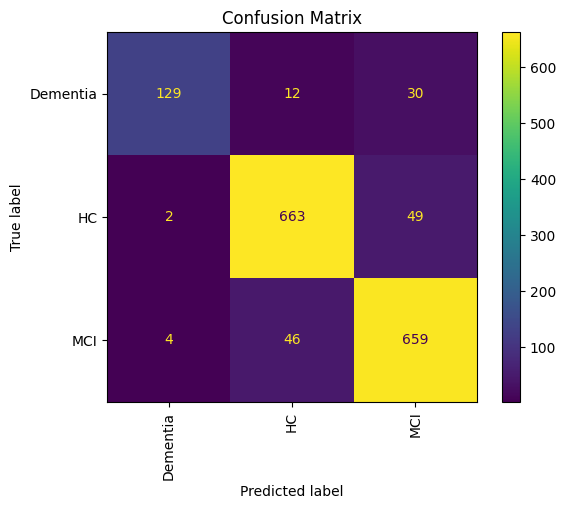

Training completed.


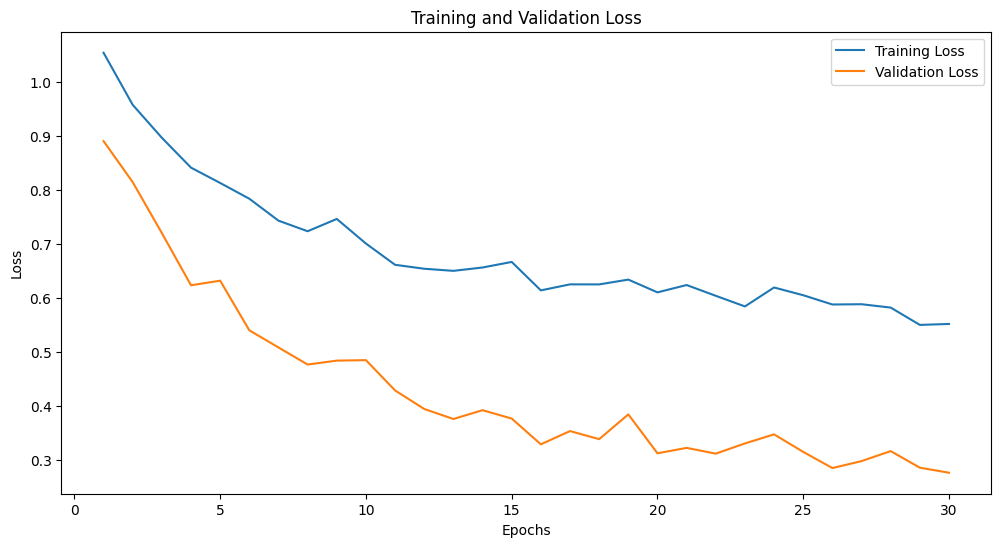

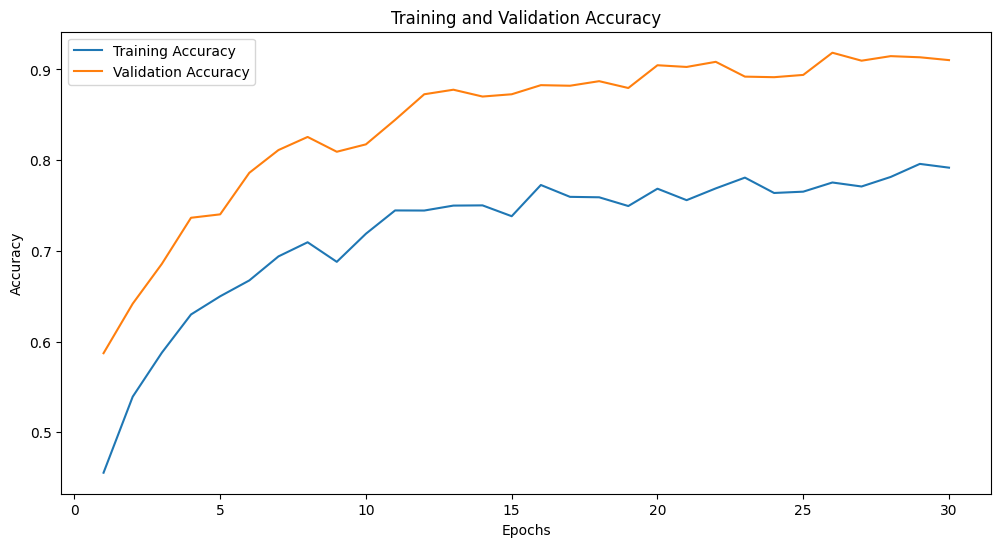

Fold 1 Results - Accuracy: 0.9103, F1: 0.9095, Precision: 0.9116, Recall: 0.9103

--- Fold 2/5 ---


C:\Users\Peter\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 1.0530, Train Acc: 0.4590
Val Loss: 0.9039, Val Acc: 0.5508
Val F1 Score: 0.5424, Precision: 0.5898, Recall: 0.5508
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 2/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9784, Train Acc: 0.5277
Val Loss: 0.8075, Val Acc: 0.6123
Val F1 Score: 0.6194, Precision: 0.6465, Recall: 0.6123
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 3/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9152, Train Acc: 0.5692
Val Loss: 0.7048, Val Acc: 0.6907
Val F1 Score: 0.6911, Precision: 0.7024, Recall: 0.6907
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 4/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8794, Train Acc: 0.6051
Val Loss: 0.6595, Val Acc: 0.7208
Val F1 Score: 0.7262, Preci

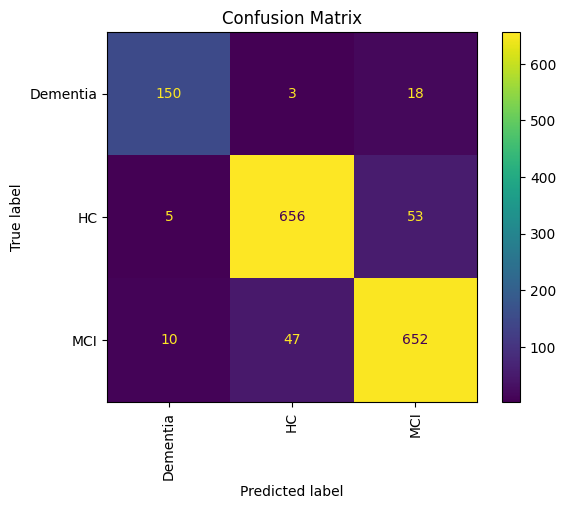

Training completed.


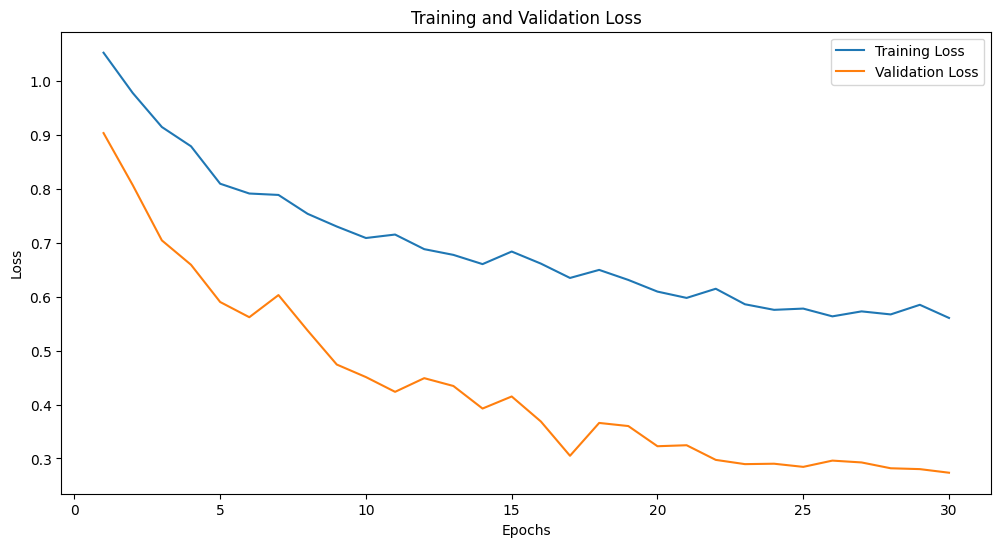

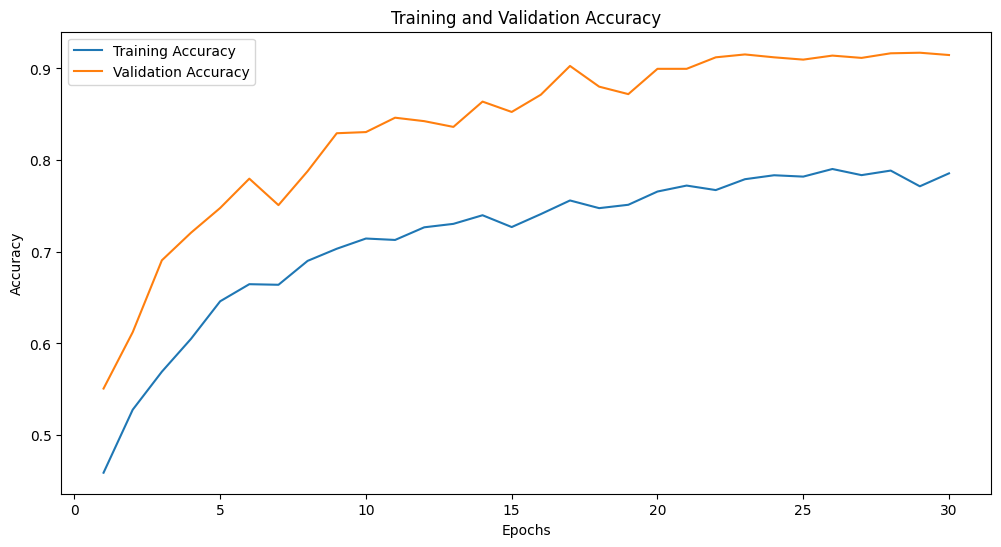

Fold 2 Results - Accuracy: 0.9147, F1: 0.9147, Precision: 0.9148, Recall: 0.9147

--- Fold 3/5 ---


C:\Users\Peter\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 1.0497, Train Acc: 0.4527
Val Loss: 0.9552, Val Acc: 0.5151
Val F1 Score: 0.5345, Precision: 0.5929, Recall: 0.5151
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 2/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9605, Train Acc: 0.5403
Val Loss: 0.7693, Val Acc: 0.6675
Val F1 Score: 0.6689, Precision: 0.6710, Recall: 0.6675
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 3/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9064, Train Acc: 0.5786
Val Loss: 0.6937, Val Acc: 0.7208
Val F1 Score: 0.7198, Precision: 0.7220, Recall: 0.7208
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 4/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8350, Train Acc: 0.6372
Val Loss: 0.6517, Val Acc: 0.7447
Val F1 Score: 0.7501, Preci

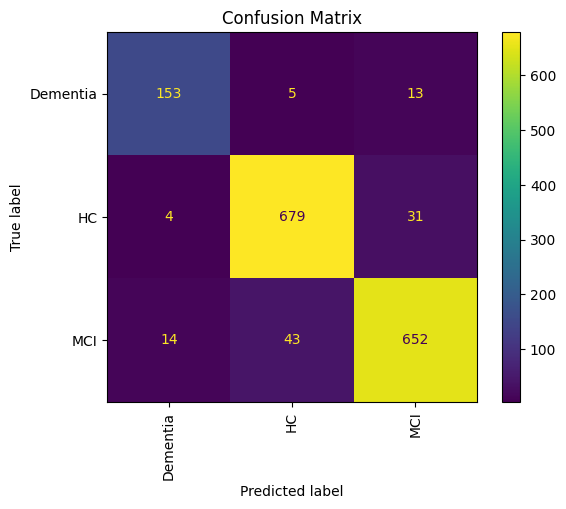

Training completed.


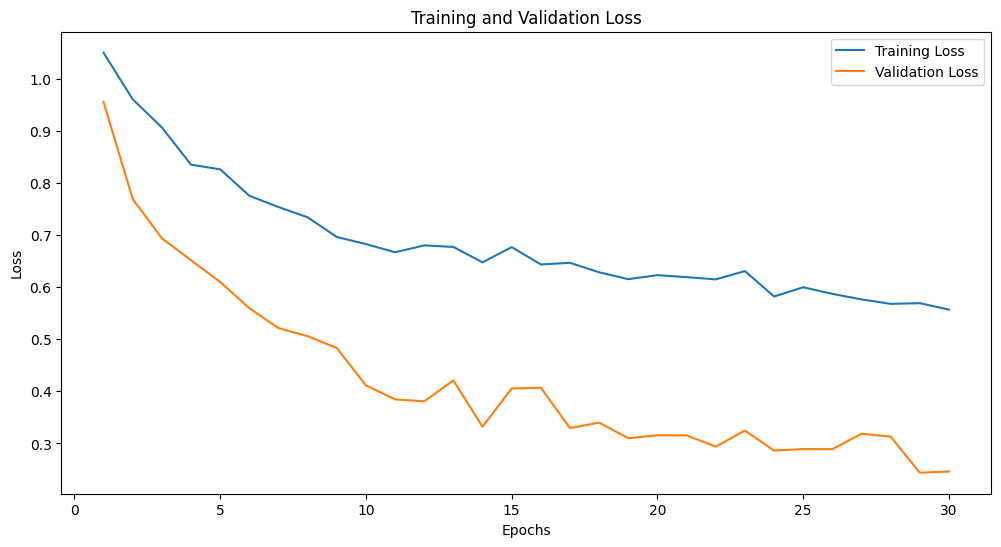

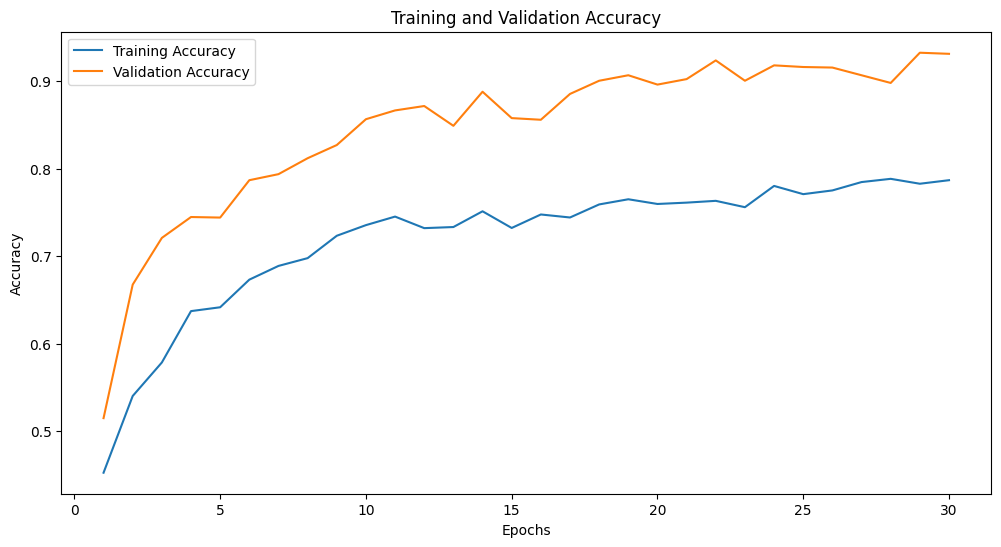

Fold 3 Results - Accuracy: 0.9310, F1: 0.9309, Precision: 0.9310, Recall: 0.9310

--- Fold 4/5 ---


C:\Users\Peter\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 1.0639, Train Acc: 0.4448
Val Loss: 0.9345, Val Acc: 0.5445
Val F1 Score: 0.5532, Precision: 0.6104, Recall: 0.5445
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 2/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9718, Train Acc: 0.5286
Val Loss: 0.7780, Val Acc: 0.6681
Val F1 Score: 0.6693, Precision: 0.6927, Recall: 0.6681
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 3/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9013, Train Acc: 0.5840
Val Loss: 0.7475, Val Acc: 0.6612
Val F1 Score: 0.6689, Precision: 0.7011, Recall: 0.6612
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 4/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8759, Train Acc: 0.6035
Val Loss: 0.6089, Val Acc: 0.7535
Val F1 Score: 0.7534, Precision: 0.7535, Reca

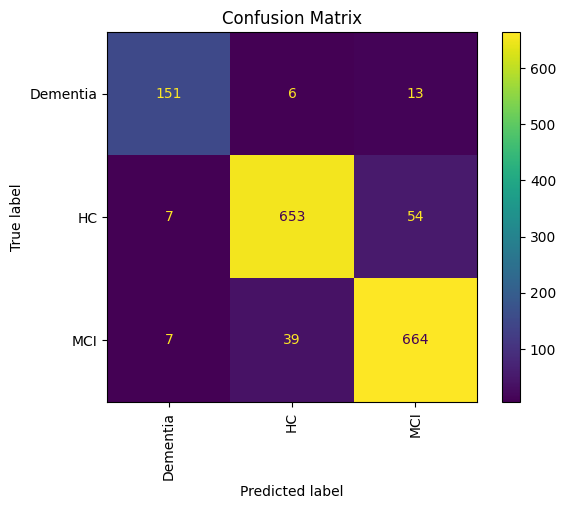

Training completed.


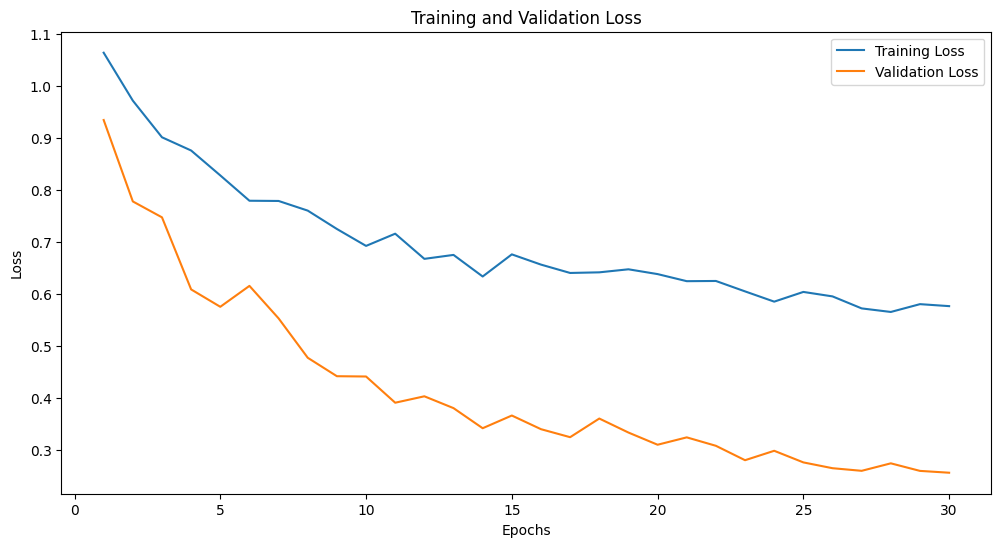

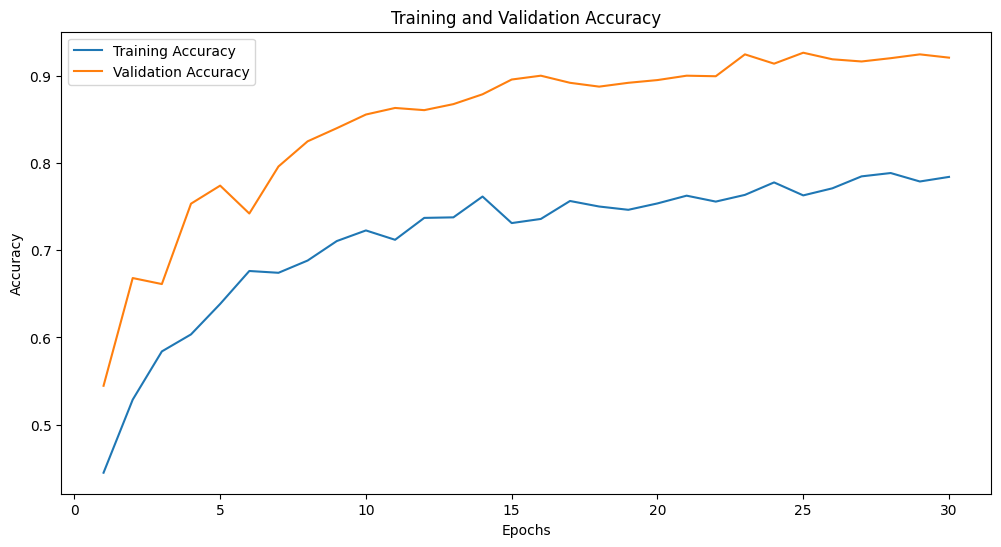

Fold 4 Results - Accuracy: 0.9210, F1: 0.9209, Precision: 0.9212, Recall: 0.9210

--- Fold 5/5 ---


C:\Users\Peter\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 1.0537, Train Acc: 0.4540
Val Loss: 0.9455, Val Acc: 0.5238
Val F1 Score: 0.5368, Precision: 0.6007, Recall: 0.5238
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 2/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9566, Train Acc: 0.5398
Val Loss: 0.7920, Val Acc: 0.6349
Val F1 Score: 0.6341, Precision: 0.6467, Recall: 0.6349
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 3/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.9136, Train Acc: 0.5826
Val Loss: 0.6982, Val Acc: 0.7108
Val F1 Score: 0.7122, Precision: 0.7169, Recall: 0.7108
Best model saved!
Unique classes in labels: [0 1 2]
Unique classes in predictions: [0 1 2]

Epoch 4/30, Learning Rate: 0.000100, Weight Decay: 0.000100
Train Loss: 0.8422, Train Acc: 0.6265
Val Loss: 0.7025, Val Acc: 0.7014
Val F1 Score: 0.7117, Preci

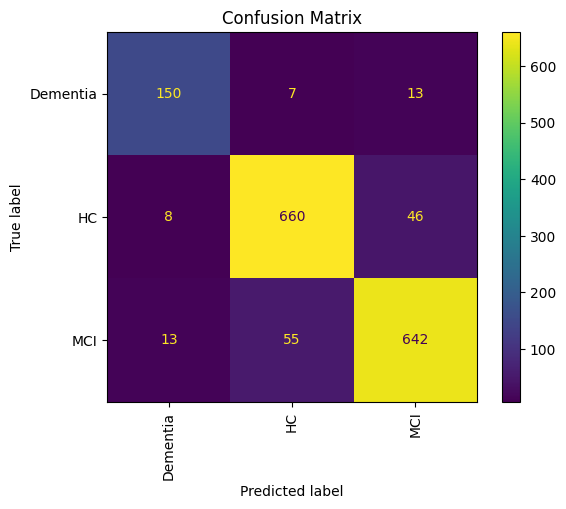

Training completed.


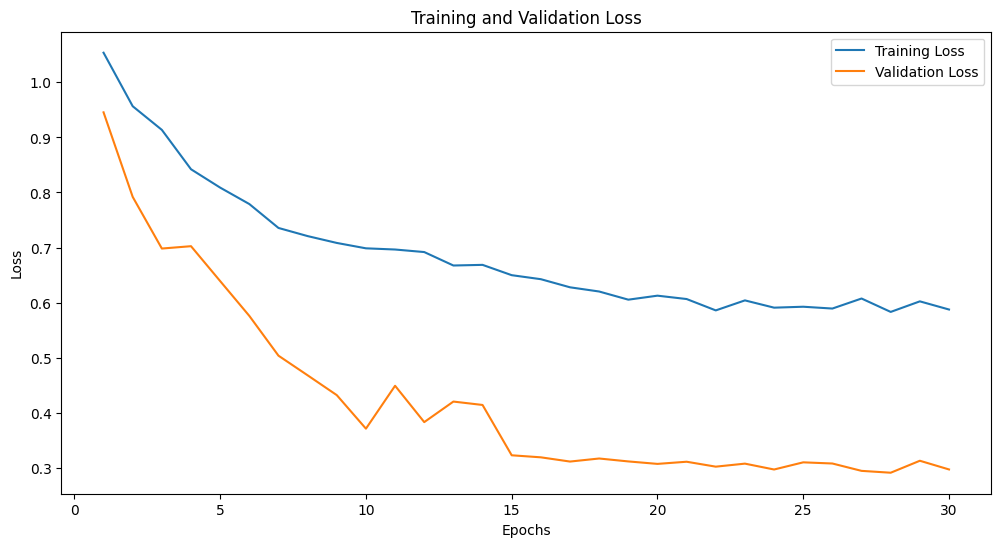

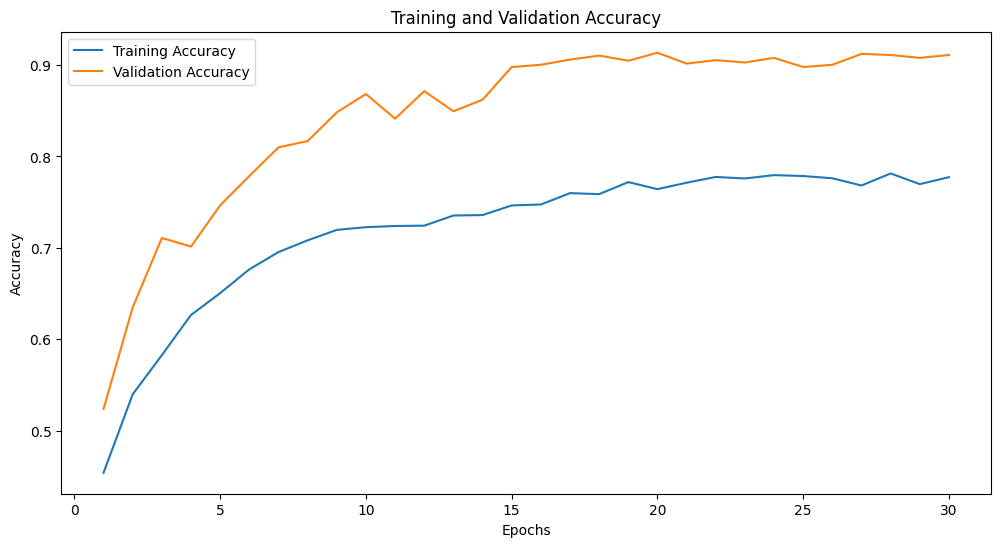

Fold 5 Results - Accuracy: 0.9109, F1: 0.9109, Precision: 0.9109, Recall: 0.9109

--- Cross-Validation Results ---
{'Accuracy': 0.9175658720200752, 'F1': 0.9173898284363411, 'Precision': 0.9179282338562818, 'Recall': 0.9175658720200752}

Accuracy - Max: 0.9310 (Fold 3), Min: 0.9103 (Fold 1), Mean: 0.9176, Std Dev: 0.0077

F1 - Max: 0.9309 (Fold 3), Min: 0.9095 (Fold 1), Mean: 0.9174, Std Dev: 0.0078

Precision - Max: 0.9310 (Fold 3), Min: 0.9109 (Fold 5), Mean: 0.9179, Std Dev: 0.0075

Recall - Max: 0.9310 (Fold 3), Min: 0.9103 (Fold 1), Mean: 0.9176, Std Dev: 0.0077
Average cross-validation results saved as final_spectrogram_classifier_dynamic_2025-01-19.pth


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, ConcatDataset
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Define model factory function
def model_fn(num_classes):
    from torchvision.models import mobilenet_v2
    model = mobilenet_v2(weights="IMAGENET1K_V1")
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

# Define optimizer factory function
def optimizer_fn(model_parameters, lr=0.0001, weight_decay=1e-4):
    return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)

# Define metric calculation
def calculate_metrics(y_true, y_pred, average='weighted'):
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    return f1, precision, recall

# Define CutMix
def cutmix(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    H, W = data.size(2), data.size(3)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    data[:, :, bby1:bby2, bbx1:bbx2] = shuffled_data[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (H * W))

    return data, targets, shuffled_targets, lam

# Define training and validation functions with plotting
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

def train_model_with_plots_and_explainability(model, criterion, optimizer, train_loader, val_loader, device, epochs=10, patience=5, scaler=None, class_names=None):
    best_val_f1 = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    lr = 0.0001
    alpha = 1.0
    weight_decay = 1e-4

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Define a scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}, Learning Rate: {lr:.6f}, Weight Decay: {weight_decay:.6f}")

        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (lam * predicted.eq(targets_a).sum().item() +
                              (1 - lam) * predicted.eq(targets_b).sum().item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save the best model based on validation F1 Score
        model_save_path = f"best_model.pth"
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)
            print("Best model saved!")

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
            print(f"Early stopping patience: {patience_counter}/{patience}")

        # Step the scheduler based on validation loss
        scheduler.step(val_loss)

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print("Unique classes in labels:", np.unique(all_labels))
        print("Unique classes in predictions:", np.unique(all_preds))

        # Plot confusion matrix for validation results
        if epoch == epochs - 1 or patience_counter >= patience:
            if class_names is not None:
                print("\nConfusion Matrix:")
                plot_confusion_matrix(all_labels, all_preds, class_names=class_names)

    print("Training completed.")

    # Plot training progress
    plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)

    # If you have implemented explain_with_lime, you can call it here
    # explain_with_lime(model, val_loader, device)

def train_with_cross_validation(dataset, model_fn, criterion, optimizer_fn, device, epochs=10, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    from collections import Counter

    # 1. Get all targets
    all_targets = [dataset[i][1] for i in range(len(dataset))]

    # 2. Set up stratified folding
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(dataset)), all_targets)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")

        # 3. Create Subset for train and validation
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)

        # 4. Build WeightedRandomSampler for the TRAIN subset only
        train_targets = [dataset[i][1] for i in train_idx]
        class_counts = Counter(train_targets)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

        # Build a weight for each sample in the train set
        sample_weights = [class_weights[label] for label in train_targets]

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        # 5. DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler, num_workers=2)
        val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=2)

        # 6. Instantiate a new model and move it to the device
        model = model_fn(num_classes).to(device)

        # 7. Define a new optimizer for this fold
        optimizer = optimizer_fn(model.parameters())

        # 8. Initialize a new scaler for mixed precision
        scaler = GradScaler()

        # 9. Train the model
        train_model_with_plots_and_explainability(
            model, criterion, optimizer, train_loader, val_loader, device,
            epochs=epochs, patience=5, scaler=scaler, class_names=class_names
        )

        # 10. Load the best model for evaluation
        model_save_path = f"best_model_fold_{fold + 1}.pth"
        torch.save(model.state_dict(), model_save_path)  # Save best model for this fold
        model.load_state_dict(torch.load(model_save_path))

        # Evaluate on the validation set
        val_correct, val_total, all_labels, all_preds = 0, 0, [], []

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = val_correct / val_total
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)
        fold_results.append((val_acc, val_f1, val_precision, val_recall))

        print(f"Fold {fold + 1} Results - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    # Average results across folds
    avg_results = {
        "Accuracy": sum(result[0] for result in fold_results) / n_splits,
        "F1": sum(result[1] for result in fold_results) / n_splits,
        "Precision": sum(result[2] for result in fold_results) / n_splits,
        "Recall": sum(result[3] for result in fold_results) / n_splits,
    }
    print("\n--- Cross-Validation Results ---")
    print(avg_results)
    
    # Calculate and display argmax, argmin, mean, and standard deviation for each metric
    fold_results = np.array(fold_results)
    metrics = ['Accuracy', 'F1', 'Precision', 'Recall']

    for i, metric in enumerate(metrics):
        max_value = np.max(fold_results[:, i])
        min_value = np.min(fold_results[:, i])
        mean_value = np.mean(fold_results[:, i])
        std_value = np.std(fold_results[:, i])
        max_fold = np.argmax(fold_results[:, i]) + 1  # 0-based to 1-based
        min_fold = np.argmin(fold_results[:, i]) + 1

        print(f"\n{metric} - Max: {max_value:.4f} (Fold {max_fold}), "
              f"Min: {min_value:.4f} (Fold {min_fold}), "
              f"Mean: {mean_value:.4f}, Std Dev: {std_value:.4f}")
    return avg_results

# Define data directories
data_dirs = [
    "F://Peter//ML_exp//PROCESS-V1//Spectrograms_3",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_10s",
    "F://Peter//ML_exp//PROCESS-V1//spectograms_3_20s"
]

# Dynamically get the list of classes based on the first folder
class_names = sorted(next(os.walk(data_dirs[0]))[1])
num_classes = len(class_names)
print(f"Detected classes: {class_names}, Number of classes: {num_classes}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Combine all datasets into one
datasets_list = [datasets.ImageFolder(data_dir, transform=transform) for data_dir in data_dirs]
combined_dataset = ConcatDataset(datasets_list)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Cross-Validation Training
avg_results = train_with_cross_validation(
    dataset=combined_dataset,
    model_fn=model_fn,
    criterion=nn.CrossEntropyLoss(),
    optimizer_fn=optimizer_fn,
    device=device,
    epochs=30,
    n_splits=5
)

# Optionally, save the aggregated results
current_date = datetime.now().strftime("%Y-%m-%d")
filename = f"final_spectrogram_classifier_dynamic_{current_date}.pth"
torch.save(avg_results, filename)  # Save the average results, not the model
print(f"Average cross-validation results saved as {filename}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# Example model architecture (replace with your own)
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Dummy forward pass
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

def objective(trial):
    """
    Objective function for Optuna hyperparameter search.
    Returns: validation F1 score
    """

    # --- Suggest hyperparameters ---
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 0.2, 1.0)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    epochs = 5  # Keep this short for quick trials; you can adjust as needed.

    # --- Build your model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyModel(num_classes=len(class_names)).to(device)

    # Define loss, optimizer, etc.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler()

    # --- Tracking metrics ---
    best_val_f1 = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply CutMix (assumed you have this function defined)
            inputs, targets_a, targets_b, lam = cutmix(inputs, labels, alpha=alpha)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Compute training loss & accuracy
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += (
                lam * predicted.eq(targets_a).sum().item()
                + (1 - lam) * predicted.eq(targets_b).sum().item()
            )

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Calculate metrics (assumed you have this function)
        val_f1, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

        # Save the best model based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    # Return the best validation F1 of this trial
    return best_val_f1
